# Model Training: Forwards - Linear Regression

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

In [101]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. TOTAL POINTS - although we may want to split this up into TOTAL ASSISTS and GOALS instead
3. TOTAL ASSISTS - although we may want to split this up into FIRST ASSISTS and SECOND ASSISTS instead
4. XGF/60 - This may not make sense to use, since it is so closely tied to XGA, which is part of the intersection
5. ON THE FLY STARTS/60 - This is probably covered by TOI/GP which it has a -.75 correlation with
6. OFF. ZONE FACEOFFS/60 - May make sense to be integrated into the PCA as it is a bit of a nuanced statistic
7. TOTAL POINTS/60 - Is too closely linked to TOTAL POINTS. We should use one or the other.
8. SHOTS - I think this would be a good metric to try to include.
9. GOALS - I think it goes without saying that we should use Goals.
10. We may want to include 'LDGF', 'OFF. ZONE STARTS', 'LDCF', 'MDGF', 'OFF. ZONE FACEOFFS',
       'HDCF', 'CF', 'FF', 'SF', 'MDCF', 'SCF', 'XGF', 'ICF', 'HDGF', 'IFF',
       'ISCF', 'IXG', 'GF' as a PCA

In [126]:
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])]

# Select only players with 60 or more games played
forwards = forwards[(forwards['GP'] >= 41)]

# Remove players from season 2023-24    
forwards = forwards[(forwards['SEASON'] != '2023-24')]

# Remove outliers
test_train_data = forwards

# Select the features we want to use# Define the feature sets more clearly
numerical_features = ['FIRST ASSISTS', 'SECOND ASSISTS', 'GOALS']  # These are to be scaled but not reduced - removed: 'XGF/60' , 'SHOTS'
pca_features = [] #['LDGF', 'OFF.\xa0ZONE STARTS', 'LDCF', 'MDGF', 'OFF.\xa0ZONE FACEOFFS',
                #'HDCF', 'CF', 'FF', 'SF', 'MDCF', 'SCF', 'XGF', 'ICF', 'HDGF', 
                #'IFF', 'ISCF', 'IXG', 'GF', 'XGF/60', 'SHOTS']  # Features for PCA

# Define transformers for the column transformer
transformers = [
    ('num', StandardScaler(), numerical_features),
    ('pca', make_pipeline(StandardScaler(), PCA(n_components=0)), pca_features)
]

preprocessor = ColumnTransformer(transformers=transformers)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X = test_train_data.drop('SALARY CAP PERCENTAGE', axis=1)
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0006759159351315915


In [127]:
# forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])]

# # Select only players with 60 or more games played
# forwards = forwards[(forwards['GP'] >= 41)]

# # Remove players from season 2023-24    
# forwards = forwards[(forwards['SEASON'] != '2023-24')]

# # Remove outliers
# test_train_data = forwards

# numerical_features = ['LDGF', 'OFF.\xa0ZONE STARTS', 'LDCF', 'MDGF', 'OFF.\xa0ZONE FACEOFFS',
#        'HDCF', 'CF', 'FF', 'SF', 'MDCF', 'SCF', 'XGF', 'ICF', 'HDGF', 'IFF',
#        'ISCF', 'IXG', 'GF'] + ['FIRST ASSISTS', 'SECOND ASSISTS', 'GOALS', 'XGF/60' ,'SHOTS', 'TOI/GP', 'TOTAL POINTS', 'TOTAL ASSISTS']

# # Define transformers for the numerical features
# transformers = [
#     ('num', StandardScaler(), numerical_features)
# ]

# preprocessor = ColumnTransformer(transformers=transformers)

# # Define a linear regression model
# linear_regression_model = LinearRegression()

# # Define the Sequential Feature Selector with the Linear Regression model
# sfs = SequentialFeatureSelector(linear_regression_model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error')

# # Create a pipeline that includes the preprocessor, SFS, and the regressor
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('sfs', sfs),
#     ('regressor', linear_regression_model)
# ])

# # Split your data
# X = test_train_data[numerical_features]  # Ensure these are the features before any dropping
# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the pipeline
# pipeline.fit(X_train, y_train)

# # Make predictions
# y_pred = pipeline.predict(X_test)

# # Calculate MSE
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

In [128]:
coefficients = pipeline.named_steps['regressor'].coef_
feature_names = numerical_features
coefficient_names = feature_names

for name, coef in zip(coefficient_names, coefficients):
    print(f'{name}: {coef}')


FIRST ASSISTS: 0.009336868825069298
SECOND ASSISTS: 0.006493916425436749
GOALS: 0.006773972482869695


In [129]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [130]:
# Create a feature column in Centers for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [131]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(20)
top_20[['PLAYER', 'SEASON', 'AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
11482,connor mcdavid,2022-23,"$12,500,000.00","$12,454,276.00","$-45,724.00",0.150961
8516,nikita kucherov,2018-19,"$4,766,667.00","$10,533,440.00","$5,766,773.00",0.132496
11774,leon draisaitl,2022-23,"$8,500,000.00","$10,574,444.00","$2,074,444.00",0.128175
10590,connor mcdavid,2021-22,"$12,500,000.00","$10,253,157.00","$-2,246,843.00",0.125806
10815,jonathan huberdeau,2021-22,"$5,900,000.00","$9,985,560.00","$4,085,560.00",0.122522
11911,nikita kucherov,2022-23,"$9,500,000.00","$9,925,831.00","$425,831.00",0.120313
1235,henrik sedin,2009-10,"$6,100,000.00","$6,793,463.00","$693,463.00",0.119603
8093,connor mcdavid,2018-19,"$12,500,000.00","$9,484,095.00","$-3,015,905.00",0.119297
10808,johnny gaudreau,2021-22,"$6,750,000.00","$9,664,436.00","$2,914,436.00",0.118582
636,evgeni malkin,2008-09,"$3,834,200.00","$6,710,003.00","$2,875,803.00",0.118342


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Centers')

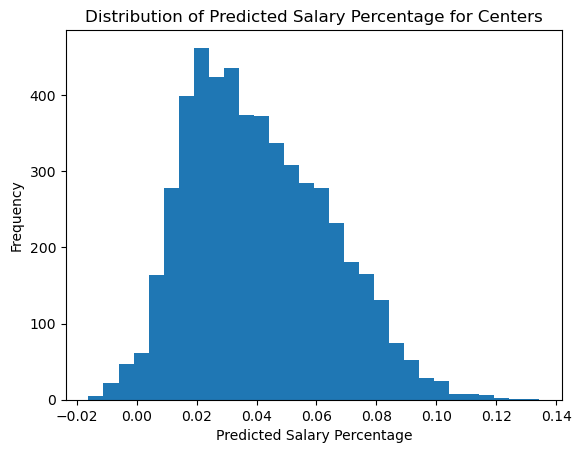

In [125]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Centers')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Centers')

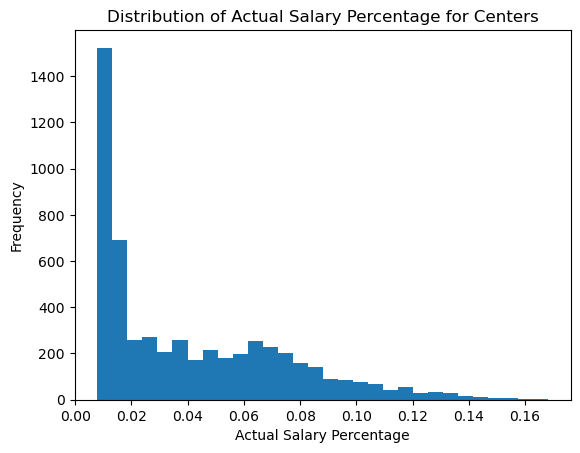

In [59]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Centers')

In [ ]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,GP,TOTAL ASSISTS/60,GOALS/60,SCF/60,FF/60,HDCF/60,CF/60,...,XGF/60,GF/60,ON THE FLY STARTS/60,OFF. ZONE FACEOFFS/60,HDGF/60,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,AAV,PRED_AAV,Differential
12849,car,seth jarvis,2023-24,70,1.38,1.19,33.81,50.70,14.32,71.71,...,3.78,4.50,33.31,26.52,2.02,0.010709,0.080128,"$1,394,167.00","$6,690,722.00",5296555.0
12398,fla,evan rodrigues,2023-24,67,1.50,0.58,34.85,55.43,14.97,77.04,...,3.89,3.47,41.09,24.04,2.02,0.035928,0.098288,"$3,000,000.00","$8,207,066.00",5207066.0
12506,min,joel eriksson ek,2023-24,66,1.37,1.28,36.27,52.44,15.51,71.92,...,4.29,4.63,25.87,26.93,1.98,0.062874,0.096753,"$5,250,000.00","$8,078,856.00",2828856.0
12705,ari,nick bjugstad,2023-24,68,1.07,0.86,27.92,42.05,11.34,57.06,...,3.12,3.20,39.31,17.19,1.22,0.025150,0.056120,"$2,100,000.00","$4,686,000.00",2586000.0
12629,wpg,mark scheifele,2023-24,62,1.96,1.05,33.88,49.40,14.23,68.09,...,3.92,4.50,31.29,31.58,2.49,0.073353,0.098489,"$6,125,000.00","$8,223,813.00",2098813.0
12619,min,marco rossi,2023-24,70,0.88,0.94,31.65,48.17,13.04,67.40,...,3.28,2.75,40.64,22.19,1.46,0.010339,0.044598,"$1,713,333.00","$3,723,967.00",2010634.0
12296,col,casey mittelstadt,2023-24,67,1.73,0.79,30.93,49.04,12.27,65.46,...,3.43,4.30,34.69,27.66,1.39,0.029940,0.045192,"$2,500,000.00","$3,773,520.00",1273520.0
12298,vgk,chandler stephenson,2023-24,65,1.35,0.75,27.70,44.17,11.68,61.39,...,3.24,3.19,35.58,26.95,1.55,0.032934,0.044662,"$2,750,000.00","$3,729,269.00",979269.0
12294,fla,carter verhaeghe,2023-24,69,1.74,1.45,45.34,61.39,19.04,87.24,...,4.89,5.08,37.94,29.15,2.56,0.049900,0.060856,"$4,166,667.00","$5,081,473.00",914806.0
12759,vgk,paul cotter,2023-24,65,1.07,0.50,28.93,41.22,11.07,59.22,...,2.70,2.29,42.79,16.93,1.21,0.009281,0.020160,"$775,000.00","$1,683,393.00",908393.0


In [ ]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,GP,TOTAL ASSISTS/60,GOALS/60,SCF/60,FF/60,HDCF/60,CF/60,...,XGF/60,GF/60,ON THE FLY STARTS/60,OFF. ZONE FACEOFFS/60,HDGF/60,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,AAV,PRED_AAV,Differential
12866,tbl,steven stamkos,2023-24,66,1.79,1.34,36.67,51.46,13.50,72.06,...,4.03,4.76,34.04,29.58,1.79,0.101796,0.101266,"$8,500,000.00","$8,455,741.00",-44259.0
12828,van,sam lafferty,2023-24,67,0.82,0.82,24.58,36.19,10.49,52.30,...,2.44,2.62,60.17,15.29,1.87,0.013772,0.013217,"$1,150,000.00","$1,103,591.00",-46409.0
12678,cgy,mikael backlund,2023-24,68,1.05,0.68,29.40,46.67,12.03,63.53,...,3.58,3.10,38.42,16.59,1.60,0.064072,0.063502,"$5,350,000.00","$5,302,385.00",-47615.0
12878,ott,tim stützle,2023-24,68,1.96,0.71,36.41,53.17,14.30,74.36,...,3.96,3.71,41.71,24.86,1.75,0.100000,0.099277,"$8,350,000.00","$8,289,667.00",-60333.0
12385,van,elias lindholm,2023-24,70,1.17,0.56,29.14,45.07,12.04,62.98,...,3.38,2.85,35.74,27.15,1.17,0.058084,0.057107,"$4,850,000.00","$4,768,468.00",-81532.0
12314,wpg,cole perfetti,2023-24,63,1.18,0.97,28.07,48.45,11.92,67.03,...,3.05,3.40,46.37,25.51,1.66,0.010709,0.017854,"$1,627,500.00","$1,490,813.00",-136687.0
12574,fla,kevin stenlund,2023-24,68,0.28,0.70,16.95,31.86,7.21,45.45,...,2.04,1.47,50.35,12.96,0.56,0.011976,0.010160,"$1,000,000.00","$848,335.00",-151665.0
12227,tor,auston matthews,2023-24,67,1.36,2.42,42.82,57.34,19.50,78.20,...,4.64,5.31,34.66,27.40,2.63,0.139404,0.137511,"$11,640,250.00","$11,482,197.00",-158053.0
12799,stl,robert thomas,2023-24,70,2.04,0.94,34.67,48.89,13.61,66.88,...,3.92,3.92,28.66,26.29,1.84,0.097305,0.095257,"$8,125,000.00","$7,953,966.00",-171034.0
12528,cgy,jonathan huberdeau,2023-24,67,1.75,0.46,35.74,52.46,14.19,74.52,...,3.98,3.29,42.63,31.52,1.65,0.125749,0.123696,"$10,500,000.00","$10,328,579.00",-171421.0


In [ ]:
# Truncate the lowest valued predictions to the minimum value for each season

# Step 1: Group the data by 'SEASON' and find the minimum value of 'Y_SALARY_CAP_PERCENTAGE' for each season
min_salary_by_season = centers.groupby('SEASON')['SALARY CAP PERCENTAGE'].min()

# Step 2: Merge the minimum values back into the original dataframe based on the 'SEASON' column
centers = centers.merge(min_salary_by_season, on='SEASON', suffixes=('', '_MIN'))

# Step 3: Update the predictions in 'PRED_SALARY_PERCENTAGE' column if they are lower than the minimum value
centers['PRED_SALARY_PERCENTAGE'] = centers.apply(lambda row: max(row['PRED_SALARY_PERCENTAGE'], row['SALARY CAP PERCENTAGE_MIN']), axis=1)

# Step 4: Update the 'PRED_SALARY_PERCENTAGE' column in the dataframe with the updated predictions
centers['PRED_SALARY_PERCENTAGE'] = centers['PRED_SALARY_PERCENTAGE']
